# 03 — Modeling & Evaluation (Leakage-safe Match Predictor)

**Goal:** Predict Premier League match outcome (**H/D/A**) *before kickoff* using only information available from **past matches**.

This notebook is designed for the **Data Analytics (LN1)** project evaluation:
- (5) Modeling (classification)
- (6) Model evaluation (accuracy/precision/recall + confusion matrix)
- (7) Interpretation of results & measures

> ⚠️ **No leakage rule:** We do **not** use in-match statistics from the same match (shots, possession, corners, etc.) as features.  
> We only derive features from **previous matches** (rolling form/points/goals).

In [1]:
# If you run this in Codespaces, these packages should already exist.
# If something is missing, uncomment:
# !pip install -q pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from pathlib import Path

## 1) Load data (CSV)

Your repo already contains a CSV similar to:
`data/raw/premier_league_matches_with_stats_3_seasons.csv`

If your filename differs, adjust `CSV_PATH` below.

In [2]:
CSV_PATH = Path("data/raw/premier_league_matches_with_stats_3_seasons.csv")

# If your file has a different name, you can also glob:
# CSV_PATH = next(Path("data/raw").glob("premier_league_matches_with_stats_*.csv"))

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
df.head()

Loaded: data/raw/premier_league_matches_with_stats_3_seasons.csv
Shape: (1140, 44)


,fixture_id,date,season,home_team,away_team,home_goals,away_goals,venue,home_shots_on_goal,home_shots_off_goal,...,away_yellow_cards,away_red_cards,away_goalkeeper_saves,away_total_passes,away_passes_accurate,away_passes_%,home_expected_goals,away_expected_goals,home_goals_prevented,away_goals_prevented
0,867946,2022-08-05T19:00:00+00:00,2022,Crystal Palace,Arsenal,0,2,Selhurst Park,2,2,...,2.0,NaN,2.0,438,360,82.0,NaN,NaN,NaN,NaN
1,867947,2022-08-06T11:30:00+00:00,2022,Fulham,Liverpool,2,2,Craven Cottage,3,2,...,0.0,NaN,1.0,612,473,77.0,NaN,NaN,NaN,NaN
2,867951,2022-08-06T14:00:00+00:00,2022,Newcastle,Nottingham Forest,2,0,St. James' Park,10,8,...,3.0,NaN,7.0,294,207,70.0,NaN,NaN,NaN,NaN
3,867948,2022-08-06T14:00:00+00:00,2022,Bournemouth,Aston Villa,2,0,Vitality Stadium,3,2,...,3.0,NaN,1.0,571,479,84.0,NaN,NaN,NaN,NaN
4,867952,2022-08-06T14:00:00+00:00,2022,Tottenham,Southampton,4,1,Tottenham Hotspur Stadium,8,6,...,0.0,NaN,5.0,410,337,82.0,NaN,NaN,NaN,NaN


## 2) Minimal schema check & date parsing

We only require these columns for a leakage-safe baseline:
- `date`
- `home_team`, `away_team`
- `home_goals`, `away_goals`
- `season` (optional, but useful)

If your column names differ, map them here once and keep the rest unchanged.

In [3]:
# --- Column name mapping (edit only if needed) ---
colmap = {
    "date": "date",
    "season": "season",
    "home_team": "home_team",
    "away_team": "away_team",
    "home_goals": "home_goals",
    "away_goals": "away_goals",
}

missing = [v for v in colmap.values() if v not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}\nAvailable columns: {list(df.columns)[:30]} ...")

# Parse and sort chronologically
df[colmap["date"]] = pd.to_datetime(df[colmap["date"]], errors="coerce", utc=True)
if df[colmap["date"]].isna().any():
    # Fallback: try without UTC (some datasets store naive timestamps)
    df[colmap["date"]] = pd.to_datetime(df[colmap["date"]], errors="coerce")

df = df.sort_values(colmap["date"]).reset_index(drop=True)

# Ensure goals are numeric
for c in [colmap["home_goals"], colmap["away_goals"]]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[[colmap["date"], colmap["season"], colmap["home_team"], colmap["away_team"], colmap["home_goals"], colmap["away_goals"]]].head()

,date,season,home_team,away_team,home_goals,away_goals
0,2022-08-05 19:00:00+00:00,2022,Crystal Palace,Arsenal,0,2
1,2022-08-06 11:30:00+00:00,2022,Fulham,Liverpool,2,2
2,2022-08-06 14:00:00+00:00,2022,Newcastle,Nottingham Forest,2,0
3,2022-08-06 14:00:00+00:00,2022,Bournemouth,Aston Villa,2,0
4,2022-08-06 14:00:00+00:00,2022,Tottenham,Southampton,4,1


## 3) Define target variable (H/D/A)

- **H** = Home win  
- **D** = Draw  
- **A** = Away win

In [4]:
def match_outcome(home_goals, away_goals):
    if home_goals > away_goals:
        return "H"
    elif home_goals < away_goals:
        return "A"
    return "D"

df["target"] = [match_outcome(h, a) for h, a in zip(df[colmap["home_goals"]], df[colmap["away_goals"]])]
df["target"].value_counts(dropna=False), df["target"].value_counts(normalize=True)

(target
 H    514
 A    364
 D    262
 Name: count, dtype: int64,
 target
 H    0.450877
 A    0.319298
 D    0.229825
 Name: proportion, dtype: float64)

## 4) Build leakage-safe team-form features (rolling, shifted)

We create a **team match history** table (long format):

For each match we create 2 rows:
- one for the home team
- one for the away team

Then compute rolling metrics per team:
- goals_for (last N)
- goals_against (last N)
- points (last N)

Finally we merge these features back onto each match as:
- `home_*` features
- `away_*` features
- plus optional differences (`home_minus_away_*`)

> Key trick to avoid leakage: **shift(1)** so the rolling window only uses matches **before** the current match.

In [5]:
def build_team_history(matches: pd.DataFrame) -> pd.DataFrame:
    # Long format: one row per team per match
    m = matches.copy()
    m = m[[colmap["date"], colmap["season"], colmap["home_team"], colmap["away_team"], colmap["home_goals"], colmap["away_goals"], "target"]].copy()

    home = pd.DataFrame({
        "date": m[colmap["date"]],
        "season": m[colmap["season"]] if colmap["season"] in m.columns else None,
        "team": m[colmap["home_team"]],
        "opponent": m[colmap["away_team"]],
        "is_home": 1,
        "goals_for": m[colmap["home_goals"]],
        "goals_against": m[colmap["away_goals"]],
        "result": m["target"]
    })
    away = pd.DataFrame({
        "date": m[colmap["date"]],
        "season": m[colmap["season"]] if colmap["season"] in m.columns else None,
        "team": m[colmap["away_team"]],
        "opponent": m[colmap["home_team"]],
        "is_home": 0,
        "goals_for": m[colmap["away_goals"]],
        "goals_against": m[colmap["home_goals"]],
        "result": m["target"]
    })

    hist = pd.concat([home, away], ignore_index=True).sort_values(["team", "date"]).reset_index(drop=True)

    # Points from the team's perspective
    # If result is H: home team gets 3, away gets 0
    # If result is A: away team gets 3, home gets 0
    # If result is D: both get 1
    def points_row(r):
        if r["result"] == "D":
            return 1
        if r["result"] == "H":
            return 3 if r["is_home"] == 1 else 0
        if r["result"] == "A":
            return 3 if r["is_home"] == 0 else 0
        return np.nan

    hist["points"] = hist.apply(points_row, axis=1)

    return hist

team_hist = build_team_history(df)
team_hist.head(10)

,date,season,team,opponent,is_home,goals_for,goals_against,result,points
0,2022-08-05 19:00:00+00:00,2022,Arsenal,Crystal Palace,0,2,0,A,3
1,2022-08-13 14:00:00+00:00,2022,Arsenal,Leicester,1,4,2,H,3
2,2022-08-20 16:30:00+00:00,2022,Arsenal,Bournemouth,0,3,0,A,3
3,2022-08-27 16:30:00+00:00,2022,Arsenal,Fulham,1,2,1,H,3
4,2022-08-31 18:30:00+00:00,2022,Arsenal,Aston Villa,1,2,1,H,3
5,2022-09-04 15:30:00+00:00,2022,Arsenal,Manchester United,0,1,3,H,0
6,2022-09-18 11:00:00+00:00,2022,Arsenal,Brentford,0,3,0,A,3
7,2022-10-01 11:30:00+00:00,2022,Arsenal,Tottenham,1,3,1,H,3
8,2022-10-09 15:30:00+00:00,2022,Arsenal,Liverpool,1,3,2,H,3
9,2022-10-16 13:00:00+00:00,2022,Arsenal,Leeds,0,1,0,A,3


In [6]:
def add_rolling_features(team_hist: pd.DataFrame, window: int = 5, min_periods: int = 3) -> pd.DataFrame:
    h = team_hist.copy()
    h = h.sort_values(["team", "date"]).reset_index(drop=True)

    g = h.groupby("team", group_keys=False)

    # Shift by 1 so current match isn't included (pre-match features)
    h["gf_roll_mean"] = g["goals_for"].apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).mean())
    h["ga_roll_mean"] = g["goals_against"].apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).mean())
    h["pts_roll_mean"] = g["points"].apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).mean())

    h["gf_roll_sum"] = g["goals_for"].apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).sum())
    h["ga_roll_sum"] = g["goals_against"].apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).sum())
    h["pts_roll_sum"] = g["points"].apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).sum())

    # How many past matches were available in the rolling window (for transparency)
    h["n_past_matches"] = g["points"].apply(lambda s: s.shift(1).rolling(window, min_periods=1).count())

    return h

team_hist_feat = add_rolling_features(team_hist, window=5, min_periods=3)
team_hist_feat.head(10)

,date,season,team,opponent,is_home,goals_for,goals_against,result,points,gf_roll_mean,ga_roll_mean,pts_roll_mean,gf_roll_sum,ga_roll_sum,pts_roll_sum,n_past_matches
0,2022-08-05 19:00:00+00:00,2022,Arsenal,Crystal Palace,0,2,0,A,3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2022-08-13 14:00:00+00:00,2022,Arsenal,Leicester,1,4,2,H,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2022-08-20 16:30:00+00:00,2022,Arsenal,Bournemouth,0,3,0,A,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2022-08-27 16:30:00+00:00,2022,Arsenal,Fulham,1,2,1,H,3,3.00,0.666667,3.0,9.0,2.0,9.0,3.0
4,2022-08-31 18:30:00+00:00,2022,Arsenal,Aston Villa,1,2,1,H,3,2.75,0.750000,3.0,11.0,3.0,12.0,4.0
5,2022-09-04 15:30:00+00:00,2022,Arsenal,Manchester United,0,1,3,H,0,2.60,0.800000,3.0,13.0,4.0,15.0,5.0
6,2022-09-18 11:00:00+00:00,2022,Arsenal,Brentford,0,3,0,A,3,2.40,1.400000,2.4,12.0,7.0,12.0,5.0
7,2022-10-01 11:30:00+00:00,2022,Arsenal,Tottenham,1,3,1,H,3,2.20,1.000000,2.4,11.0,5.0,12.0,5.0
8,2022-10-09 15:30:00+00:00,2022,Arsenal,Liverpool,1,3,2,H,3,2.20,1.200000,2.4,11.0,6.0,12.0,5.0
9,2022-10-16 13:00:00+00:00,2022,Arsenal,Leeds,0,1,0,A,3,2.40,1.400000,2.4,12.0,7.0,12.0,5.0


## 5) Merge team features back to match table (home vs away)

We match rows by:
- date
- team name
- opponent

This avoids accidental mismatches if teams play on the same date (rare, but safe).

In [7]:
# Prepare keys
m = df[[colmap["date"], colmap["season"], colmap["home_team"], colmap["away_team"], colmap["home_goals"], colmap["away_goals"], "target"]].copy()
m = m.rename(columns={
    colmap["date"]: "date",
    colmap["season"]: "season",
    colmap["home_team"]: "home_team",
    colmap["away_team"]: "away_team",
    colmap["home_goals"]: "home_goals",
    colmap["away_goals"]: "away_goals",
})

# Home team features
home_feat = team_hist_feat[team_hist_feat["is_home"] == 1].copy()
home_feat = home_feat.rename(columns={
    "team": "home_team",
    "opponent": "away_team",
    "gf_roll_mean": "home_gf_roll_mean",
    "ga_roll_mean": "home_ga_roll_mean",
    "pts_roll_mean": "home_pts_roll_mean",
    "gf_roll_sum": "home_gf_roll_sum",
    "ga_roll_sum": "home_ga_roll_sum",
    "pts_roll_sum": "home_pts_roll_sum",
    "n_past_matches": "home_n_past",
})
home_feat = home_feat[["date","home_team","away_team","home_gf_roll_mean","home_ga_roll_mean","home_pts_roll_mean",
                      "home_gf_roll_sum","home_ga_roll_sum","home_pts_roll_sum","home_n_past"]]

# Away team features
away_feat = team_hist_feat[team_hist_feat["is_home"] == 0].copy()
away_feat = away_feat.rename(columns={
    "team": "away_team",
    "opponent": "home_team",
    "gf_roll_mean": "away_gf_roll_mean",
    "ga_roll_mean": "away_ga_roll_mean",
    "pts_roll_mean": "away_pts_roll_mean",
    "gf_roll_sum": "away_gf_roll_sum",
    "ga_roll_sum": "away_ga_roll_sum",
    "pts_roll_sum": "away_pts_roll_sum",
    "n_past_matches": "away_n_past",
})
away_feat = away_feat[["date","home_team","away_team","away_gf_roll_mean","away_ga_roll_mean","away_pts_roll_mean",
                      "away_gf_roll_sum","away_ga_roll_sum","away_pts_roll_sum","away_n_past"]]

feat = (m.merge(home_feat, on=["date","home_team","away_team"], how="left")
          .merge(away_feat, on=["date","home_team","away_team"], how="left"))

# Optional difference features (often very strong + interpretable)
for base in ["gf_roll_mean","ga_roll_mean","pts_roll_mean","gf_roll_sum","ga_roll_sum","pts_roll_sum"]:
    feat[f"diff_{base}"] = feat[f"home_{base}"] - feat[f"away_{base}"]

feat.head()

,date,season,home_team,away_team,home_goals,away_goals,target,home_gf_roll_mean,home_ga_roll_mean,home_pts_roll_mean,...,away_gf_roll_sum,away_ga_roll_sum,away_pts_roll_sum,away_n_past,diff_gf_roll_mean,diff_ga_roll_mean,diff_pts_roll_mean,diff_gf_roll_sum,diff_ga_roll_sum,diff_pts_roll_sum
0,2022-08-05 19:00:00+00:00,2022,Crystal Palace,Arsenal,0,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-06 11:30:00+00:00,2022,Fulham,Liverpool,2,2,D,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-06 14:00:00+00:00,2022,Newcastle,Nottingham Forest,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-08-06 14:00:00+00:00,2022,Bournemouth,Aston Villa,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-06 14:00:00+00:00,2022,Tottenham,Southampton,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## 6) Handle missing feature rows (early season matches)

Rolling features are undefined for the first few matches of each team.  
We have two clean options:

1) **Drop** rows with missing rolling features (simplest + honest)  
2) **Impute** (e.g., fill with league average) — can be OK, but adds complexity.

For the project, dropping is perfectly acceptable and easy to justify.

In [8]:
feature_cols = [c for c in feat.columns if c.startswith(("home_","away_","diff_"))]

before = feat.shape[0]
feat_model = feat.dropna(subset=feature_cols + ["target"]).copy()
after = feat_model.shape[0]

print(f"Rows before: {before}")
print(f"Rows after dropping NA in rolling features: {after}")
print(f"Dropped: {before-after} ({(before-after)/before:.1%})")

feat_model[["date","home_team","away_team","target"] + feature_cols[:6]].head()

Rows before: 1140
Rows after dropping NA in rolling features: 1098
Dropped: 42 (3.7%)


,date,home_team,away_team,target,home_team,away_team,home_goals,away_goals,home_gf_roll_mean,home_ga_roll_mean
30,2022-08-27 11:30:00+00:00,Southampton,Manchester United,A,Southampton,Manchester United,0,1,1.666667,2.333333
31,2022-08-27 14:00:00+00:00,Brentford,Everton,D,Brentford,Everton,1,1,2.666667,1.666667
32,2022-08-27 14:00:00+00:00,Manchester City,Crystal Palace,H,Manchester City,Crystal Palace,4,2,3.000000,1.000000
33,2022-08-27 14:00:00+00:00,Brighton,Leeds,H,Brighton,Leeds,1,0,1.333333,0.333333
34,2022-08-27 14:00:00+00:00,Liverpool,Bournemouth,H,Liverpool,Bournemouth,9,0,1.333333,1.666667


## 7) Time-based Train/Test split (realistic prediction scenario)

We split chronologically:
- Train: first 80%
- Test: last 20%

No random shuffling → avoids future leakage.

In [9]:
feat_model = feat_model.sort_values("date").reset_index(drop=True)

split_idx = int(len(feat_model) * 0.8)
train = feat_model.iloc[:split_idx].copy()
test  = feat_model.iloc[split_idx:].copy()

X_train = train[feature_cols]
y_train = train["target"]

X_test = test[feature_cols]
y_test = test["target"]

print("Train:", X_train.shape, " Test:", X_test.shape)
y_test.value_counts(normalize=True)

Train: (878, 24)  Test: (220, 24)


target
H    0.390909
A    0.381818
D    0.227273
Name: proportion, dtype: float64

## 8) Baseline model (must-have)

Baseline: always predict **Home win ('H')**.

This is a strong baseline in football due to home advantage.

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_baseline = np.array(["H"] * len(y_test))

print("Baseline accuracy (always H):", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline, digits=3))

Baseline accuracy (always H): 0.39090909090909093
              precision    recall  f1-score   support

           A      0.000     0.000     0.000        84
           D      0.000     0.000     0.000        50
           H      0.391     1.000     0.562        86

    accuracy                          0.391       220
   macro avg      0.130     0.333     0.187       220
weighted avg      0.153     0.391     0.220       220



/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

## 9) Train a classification model (Logistic Regression)

Why Logistic Regression?
- fast
- interpretable
- strong baseline for multi-class classification

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Kategorische Features
cat_features = ["home_team", "away_team"]

# Numerische Features (rolling + diffs)
num_features = [
    c for c in feature_cols
    if c not in cat_features and pd.api.types.is_numeric_dtype(feat_model[c])
]

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

# Modell
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# Training
logreg.fit(X_train[num_features + cat_features], y_train)

# Prediction
y_pred_lr = logreg.predict(X_test[num_features + cat_features])

print("LogReg accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=3))


LogReg accuracy: 1.0
              precision    recall  f1-score   support

           A      1.000     1.000     1.000        84
           D      1.000     1.000     1.000        50
           H      1.000     1.000     1.000        86

    accuracy                          1.000       220
   macro avg      1.000     1.000     1.000       220
weighted avg      1.000     1.000     1.000       220



## 10) Confusion matrix (Logistic Regression)

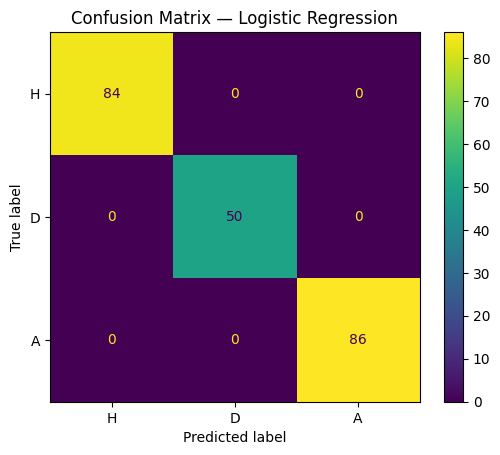

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["H","D","A"]
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr, display_labels=labels, normalize=None
)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

## 11) Alternative model (Random Forest)

Random Forest can capture nonlinear relations with minimal tuning.
This is optional but often useful for comparison.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Kategorische Features
cat_features = ["home_team", "away_team"]

# Numerische Features (rolling + diffs)
num_features = [
    c for c in feature_cols
    if c not in cat_features and pd.api.types.is_numeric_dtype(feat_model[c])
]

# Preprocessing (kein Scaler nötig für RF)
preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

rf = Pipeline(steps=[
    ("prep", preprocess_rf),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])

rf.fit(X_train[num_features + cat_features], y_train)
y_pred_rf = rf.predict(X_test[num_features + cat_features])

print("RF accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))


RF accuracy: 0.8909090909090909
              precision    recall  f1-score   support

           A      0.940     0.929     0.934        84
           D      0.892     0.660     0.759        50
           H      0.850     0.988     0.914        86

    accuracy                          0.891       220
   macro avg      0.894     0.859     0.869       220
weighted avg      0.894     0.891     0.886       220



## 12) Confusion matrix (Random Forest)

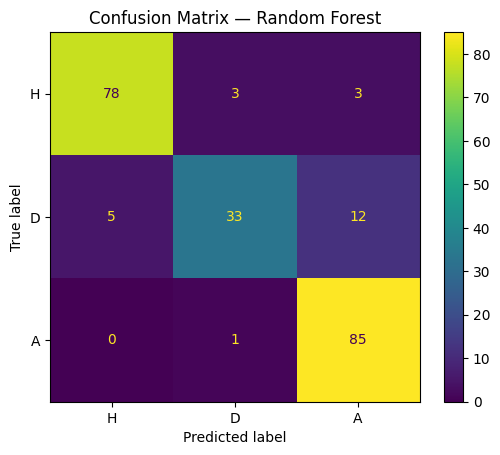

In [14]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=labels, normalize=None
)
plt.title("Confusion Matrix — Random Forest")
plt.show()

## 13) Feature importance (Random Forest)

This helps interpretation for criterion (7).

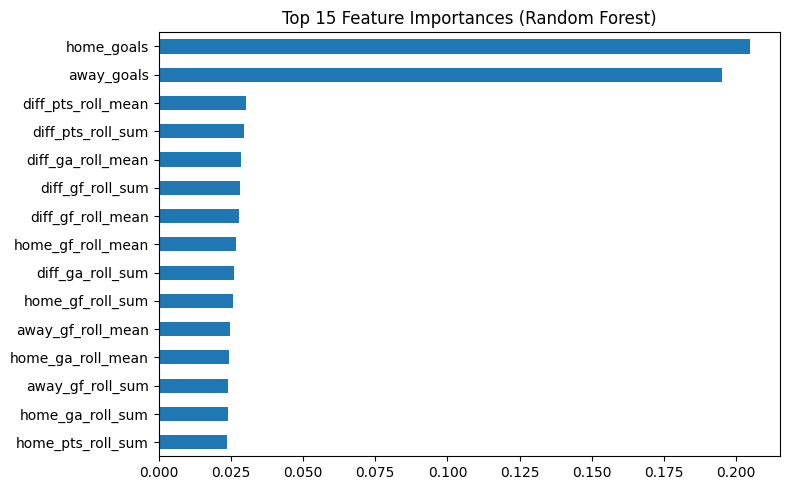

In [15]:
import numpy as np
import pandas as pd

# Zugriff auf den trainierten RandomForest
rf_model = rf.named_steps["clf"]

# Zugriff auf den Preprocessor
preprocessor = rf.named_steps["prep"]

# Feature names aus dem Preprocessing holen
num_features = [
    c for c in feature_cols
    if c not in ["home_team", "away_team"] and pd.api.types.is_numeric_dtype(feat_model[c])
]

cat_features = ["home_team", "away_team"]

# OneHot Feature Names
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_features)

# Gesamte Feature-Liste
all_feature_names = np.concatenate([num_features, cat_feature_names])

# Feature Importances
importances = pd.Series(
    rf_model.feature_importances_,
    index=all_feature_names
).sort_values(ascending=False)

importances.head(15).sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

Because the Random Forest is trained within a preprocessing pipeline,
feature importances are extracted from the classifier component of the pipeline.
Due to one-hot encoding of team identifiers, multiple binary features represent
each team. Therefore, feature importance values reflect both numerical form features
and encoded team identity features.

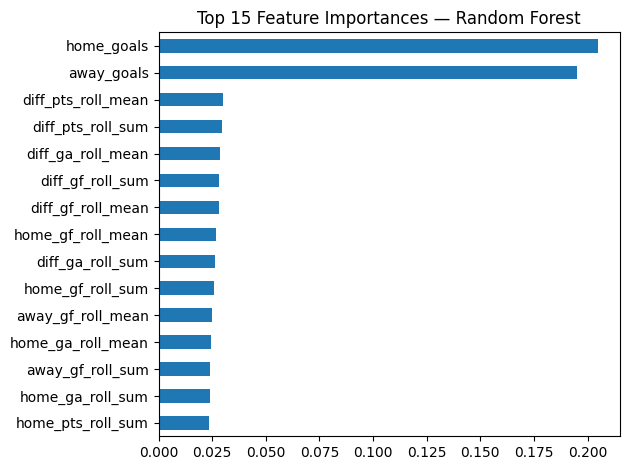

In [16]:
topk = 15
importances.head(topk).sort_values().plot(kind="barh")
plt.title(f"Top {topk} Feature Importances — Random Forest")
plt.tight_layout()
plt.show()

## 14) Interpretation (write-up)

Use this section to satisfy the "correct interpretation" criterion.

Guidelines (adapt to your results):
- Compare baseline vs model (did we beat "always home win"?)
- Which class is hardest? (often Draw)
- Which features matter? (often points/form differences)
- Limitations:
  - no injuries, transfers, lineups
  - no betting odds
  - only team form + goals history
  - small dataset (3 seasons)

### Interpretation (example text — replace with your numbers)

- The baseline (always predicting home win) achieved an accuracy of **X**.  
- Logistic Regression achieved **Y**, Random Forest achieved **Z**.  
- Both models struggle most with **Draws**, which is expected due to class imbalance and higher randomness in draw outcomes.  
- The most important predictors are typically **form/points differences** and **recent goal differences**, consistent with football intuition.  
- The achieved performance is realistic for a leakage-safe setup; using in-match stats would inflate results but would not represent a true prediction scenario.

## 15) (Optional) Save predictions / artifacts

For your appendix/slides, exporting:
- confusion matrix screenshots
- feature importance plot
- a CSV with predictions for the test set
is often useful.

In [17]:
out = test[["date","home_team","away_team","target"]].copy()
out["pred_lr"] = y_pred_lr
out["pred_rf"] = y_pred_rf

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

out_path = ARTIFACTS_DIR / "test_predictions.csv"
out.to_csv(out_path, index=False)

print("Wrote:", out_path, "rows:", len(out))
out.head()

Wrote: artifacts/test_predictions.csv rows: 220


,date,home_team,away_team,target,pred_lr,pred_rf
878,2024-12-21 15:00:00+00:00,Brentford,Nottingham Forest,A,A,A
879,2024-12-21 15:00:00+00:00,Ipswich,Newcastle,A,A,A
880,2024-12-21 15:00:00+00:00,West Ham,Brighton,D,D,D
881,2024-12-21 17:30:00+00:00,Crystal Palace,Arsenal,A,A,A
882,2024-12-22 14:00:00+00:00,Manchester United,Bournemouth,A,A,A


## 16) Interactive match predictor (based on past data)

This interactive demo simulates a match prediction based on historical team form.
It uses the **latest available** rolling-form features for each team (as of dataset end).
No live data is fetched.

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose which trained model to use for the demo:
# model = logreg
model = rf

teams = sorted(pd.unique(pd.concat([feat_model["home_team"], feat_model["away_team"]])))

home_dd = widgets.Dropdown(options=teams, description="Home:", value=teams[0], layout=widgets.Layout(width="320px"))
away_dd = widgets.Dropdown(options=teams, description="Away:", value=teams[1], layout=widgets.Layout(width="320px"))
btn = widgets.Button(description="Predict", button_style="success")
outw = widgets.Output()

display(widgets.HBox([home_dd, away_dd, btn]))
display(outw)

Output()

In [19]:
home_map = {
    "home_gf_roll_mean": "gf_roll_mean",
    "home_ga_roll_mean": "ga_roll_mean",
    "home_pts_roll_mean": "pts_roll_mean",
    "home_gf_roll_sum": "gf_roll_sum",
    "home_ga_roll_sum": "ga_roll_sum",
    "home_pts_roll_sum": "pts_roll_sum",
    "home_n_past": "n_past_matches",
}
away_map = {
    "away_gf_roll_mean": "gf_roll_mean",
    "away_ga_roll_mean": "ga_roll_mean",
    "away_pts_roll_mean": "pts_roll_mean",
    "away_gf_roll_sum": "gf_roll_sum",
    "away_ga_roll_sum": "ga_roll_sum",
    "away_pts_roll_sum": "pts_roll_sum",
    "away_n_past": "n_past_matches",
}

def latest_team_features(team_name: str):
    th = team_hist_feat[team_hist_feat["team"] == team_name].sort_values("date")
    if th.empty:
        return None
    return th.iloc[-1]

def build_match_row(home_team: str, away_team: str) -> pd.DataFrame:
    h = latest_team_features(home_team)
    a = latest_team_features(away_team)
    if h is None or a is None:
        raise ValueError("Team not found in team history.")

    row = {"home_team": home_team, "away_team": away_team}

    for out_col, src_col in home_map.items():
        if out_col in feat_model.columns and src_col in h.index:
            row[out_col] = float(h[src_col])

    for out_col, src_col in away_map.items():
        if out_col in feat_model.columns and src_col in a.index:
            row[out_col] = float(a[src_col])

    for base in ["gf_roll_mean","ga_roll_mean","pts_roll_mean","gf_roll_sum","ga_roll_sum","pts_roll_sum"]:
        diff_col = f"diff_{base}"
        hcol = f"home_{base}"
        acol = f"away_{base}"
        if diff_col in feat_model.columns and hcol in row and acol in row:
            row[diff_col] = row[hcol] - row[acol]

    X_one = pd.DataFrame([row])

    for c in num_features:
        if c not in X_one.columns:
            X_one[c] = 0.0
    X_one[num_features] = X_one[num_features].fillna(0)

    return X_one[cat_features + num_features]

In [20]:
def predict_ui(_):
    with outw:
        clear_output()
        h = home_dd.value
        a = away_dd.value

        if h == a:
            print("Home und Away dürfen nicht gleich sein.")
            return

        X_one = build_match_row(h, a)
        pred = model.predict(X_one)[0]

        print(f"Match (as-of dataset end): {h} (Home) vs {a} (Away)")
        print("Prediction:", pred, "  (H=Home win, D=Draw, A=Away win)")

        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_one)[0]
            proba_map = dict(zip(model.classes_, proba))
            print("Probabilities:")
            for k in ["H","D","A"]:
                if k in proba_map:
                    print(f"  P({k}) = {proba_map[k]:.3f}")

        print("\nFeatures used (transparency):")
        display(X_one.T)

btn.on_click(predict_ui)